### Imports + utility functions

In [1]:
import os
import geopandas as gpd
import numpy as np
import pyproj
from shapely.ops import transform
from shapely.geometry import box
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pystac_client import Client

In [2]:
# Utility functions
def get_bbox(shp_fp):
    gdf = gpd.read_file(shp_fp)
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(4326)
    bbox = tuple(gdf.total_bounds)

    return bbox

### Work through STAC catalog to find product URLs

In [3]:
# Use City of Ottawa urban boundary as test AOI
shp_fp = './Urban_Boundary.geojson'
aoi_gdf = gpd.read_file(shp_fp)
utm_crs = aoi_gdf.estimate_utm_crs().to_epsg()  # required for stackstac call
bbox = get_bbox(shp_fp)
bbox

(np.float64(-75.96666401487873),
 np.float64(45.23090774120208),
 np.float64(-75.43410167132566),
 np.float64(45.516074722660285))

In [4]:
# Filter assets by imaging date
start_date = '2025-01-01'
end_date = '2025-12-31'

In [5]:
# List all RCM-CARD items in EODMS STAC collection that intersect with area of interest
cat_url = 'https://www.eodms-sgdot.nrcan-rncan.gc.ca/stac/'
catalog = Client.open(cat_url)
search = catalog.search(
    collections=["rcm-ard"],
    bbox=bbox,
    datetime=f'{start_date}/{end_date}'
)

items = search.item_collection()

In [6]:
# Filter results by desired properties: looking for MLC products with 'CH', 'CV', and 'XC' polarizations
polarizations = ['CH', 'CV', 'XC']
product_type = 'MLC'
filtered_items = [x for x in items if x.properties['sar:polarizations'] == polarizations and x.properties['sar:product_type'] == product_type]
print(f'{len(filtered_items)} RCM-CARD products found satisfying search conditions')

2 RCM-CARD products found satisfying search conditions


In [7]:
# Get S3 URLs for all cloud-optimized GeoTIFFs needed for M-Chi decomposition
card_product = filtered_items[-1]  # working with a single product for now
order_key = card_product.properties['order_key']
rl_url, rr_url, rrrl_url = card_product.assets['RL'].href, card_product.assets['RR'].href, card_product.assets['RRRL'].href
rl_url, rr_url, rrrl_url

('https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2025/01/29/RCM2_OK3308027_PK3465360_2_SC30MCPB_20250129_111933_CH_CV_MLC/RCM2_OK3308027_PK3465360_2_SC30MCPB_20250129_111933_RL.tif',
 'https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2025/01/29/RCM2_OK3308027_PK3465360_2_SC30MCPB_20250129_111933_CH_CV_MLC/RCM2_OK3308027_PK3465360_2_SC30MCPB_20250129_111933_RR.tif',
 'https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2025/01/29/RCM2_OK3308027_PK3465360_2_SC30MCPB_20250129_111933_CH_CV_MLC/RCM2_OK3308027_PK3465360_2_SC30MCPB_20250129_111933_RRRL.tif')

#### Read data from COGs using City of Ottawa spatial subset

RRRL GeoTiff contains 2 bands (real + imaginary) so we define our own function instead of using stackstac, which only supports single-band rasters

In [8]:
def read_cog_from_bbox(cog_url, bbox=None):
    with rxr.open_rasterio(cog_url) as rds:
        # Reproject bounding box to match raster CRS
        if bbox is None:
            out_cog = rds.copy()
        else:
            bbox_geom = box(*bbox)
            cog_epsg = rds.rio.crs.to_epsg()
        
            project = pyproj.Transformer.from_proj(
                pyproj.Proj('epsg:4326'),  # hard-coded in get_bbox() function 
                pyproj.Proj(f'epsg:{cog_epsg}'),
                always_xy = True) 
            
            # Clip COG to reprojected bounds if provided and return
            bbox_geom_proj = transform(project.transform, bbox_geom)
            out_cog = rds.rio.clip_box(*bbox_geom_proj.bounds)
    
    return out_cog

### M-Chi Decomposition

#### Step 1: convert MLC rasters from RCM-CARD product to Stokes parameters

In [9]:
# Option to process entire product extent or subset by bbox
def card_to_stokes(rl_url, rr_url, rrrl_url, bbox=bbox):
    rl, rr, rrrl =  read_cog_from_bbox(rl_url, bbox), read_cog_from_bbox(rr_url, bbox), read_cog_from_bbox(rrrl_url, bbox)
    I = rl + rr
    Q = 2 * rrrl[1, :, :]  # 2nd band is imaginary component
    U = 2 * rrrl[0, :, :]  # 1st band is real component
    V = rl - rr

    return I[0], Q, U, V[0]  # drop redundant "band" dimension when exists

In [10]:
I, Q, U, V = card_to_stokes(rl_url, rr_url, rrrl_url)

#### Step 2: convert Stokes parameters to polarimetric discriminators

In [11]:
def stokes_to_pol(I, Q, U, V):
    dpol = np.sqrt(Q**2 + U**2 + V**2) / I
    chi = V / (dpol * I)

    return dpol, chi

In [12]:
dpol, chi = stokes_to_pol(I, Q, U, V)

#### Step 3: convert polarimetric discriminators to M-Chi feature decomposition

In [13]:
def pol_to_mchi(I, dpol, chi):
    single = I * dpol * (1 + chi) / 2
    volume = I * (1 - dpol)
    double = I * dpol * (1 - chi) / 2

    return single, volume, double

In [14]:
single, volume, double = pol_to_mchi(I, dpol, chi)

#### Visualize results and save to disk

In [15]:
mchi_stack = xr.concat([single, volume, double], dim='band')
mchi_stack.coords['band'] = [0, 1, 2]
mchi_stack.attrs['long_name'] = ['Single-bounce scattering', 'Volume scattering', 'Double-bounce scattering']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-110.64755..893.0917].


<Axes: title={'center': 'M-Chi Decomposition of RCM2_OK3308027_PK3465360_2_SC30MCPB_20250129_111933_CH_CV_MLC'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

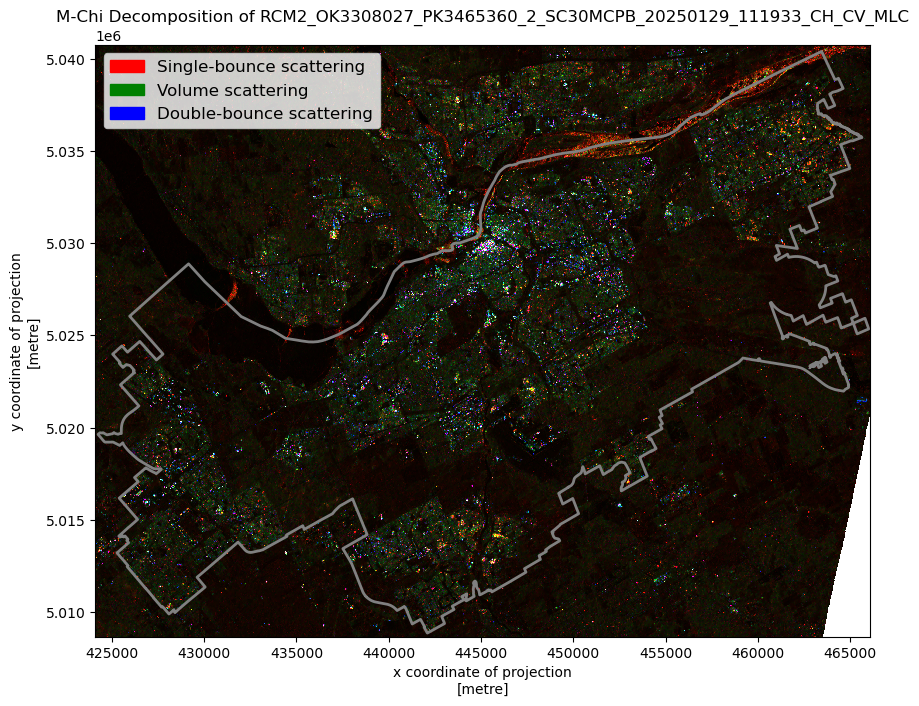

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

mchi_stack.plot.imshow(rgb='band', ax=ax)
ax.set(title=f'M-Chi Decomposition of {order_key}')

legend = zip(['red', 'green', 'blue'], mchi_stack.attrs['long_name'])
patches = [mpatches.Patch(color=color, label=label) for color, label in legend]
ax.legend(handles=patches, loc='upper left', fontsize=12)

aoi_gdf.to_crs(mchi_stack.rio.crs.to_epsg()).plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=2)

In [17]:
# Export all components as multiband GTiff
out_mchi = fr'./data/{order_key}_mchi.tif'
if not os.path.exists('./data'):
    os.mkdir('./data')
    
mchi_stack.rio.to_raster(out_mchi)

In [19]:
# Save individual scattering components named to match conventions from EODMS SAR Toolbox
components = ['surf', 'vol', 'dbl']
for i, component in enumerate(components):
    mchi_comp = mchi_stack[i]
    mchi_comp.attrs['long_name'] = [mchi_stack.attrs['long_name'][i]]
    mchi_comp.rio.to_raster(f'./data/{order_key}_mchi_{component}.tif')